<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/6_custom_cnns_vs_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU

We manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

## Setup

Having switched to GPU, let's start running the following cells to import packages.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as datasets
import torchvision.transforms as T

import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Part I. Preparation

## Load CIFAR-10 dataset

Now, let's load the CIFAR-10 dataset. PyTorch provides some convenient tools to automate this process even more for us.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the mean and standard deviation for CIFAR-10.
mean = (0.4914, 0.4822, 0.4465)  # Precomputed mean for CIFAR-10.
std = (0.2023, 0.1994, 0.2010)   # Precomputed std for CIFAR-10.

# Define the transform for preprocessing and data augmentation.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the CIFAR-10 dataset.
dataset_path = '/content/drive/MyDrive'
cifar10_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform) # Use download=True in case you do not have already downloaded.

# Split the dataset into train, val, and test sets.
num_train = 45000  # Number of training examples.
num_val = 5000    # Number of validation examples.
num_test = 10000   # Number of test examples (CIFAR-10 test set size).

train_dataset, val_dataset = random_split(cifar10_dataset, [num_train, num_val])

test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# Define DataLoaders.
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for verification.
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Files already downloaded and verified
Train set size: 45000
Validation set size: 5000
Test set size: 10000


## Visualize the class distributions

We have now defined our train, validation and test dataloaders. However, it would be good to check the data distribution of each dataloader, in order to check how many examples per class are included. We do this as a sanity check, as we want our dataloaders to be distributed close to uniform. Let's define some helper functions:

In [ ]:
import numpy as np
from collections import Counter

def get_class_distribution(loader, dataset_classes):
    """
    Computes the distribution of classes in a DataLoader.

    Args:
    - loader: DataLoader to inspect
    - dataset_classes: List of class names for the dataset

    Returns:
    - class_counts: Dictionary with class names as keys and counts as values
    """
    class_counts = Counter()
    for inputs, labels in loader:
        class_counts.update(labels.numpy())

    # Convert to a dictionary with class names.
    class_distribution = {dataset_classes[i]: class_counts[i] for i in range(len(dataset_classes))}
    return class_distribution

def display_class_distribution(distribution, title="Class Distribution"):
    """
    Displays the class distribution as a bar chart.

    Args:
    - distribution: Dictionary with class names as keys and counts as values
    - title: Title for the bar chart
    """
    import matplotlib.pyplot as plt

    class_names = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Now, let's visualize the distribution of the examples per class for each dataloader:

Train DataLoader Distribution:
  airplane: 4485
  automobile: 4506
  bird: 4514
  cat: 4477
  deer: 4471
  dog: 4521
  frog: 4505
  horse: 4496
  ship: 4511
  truck: 4514


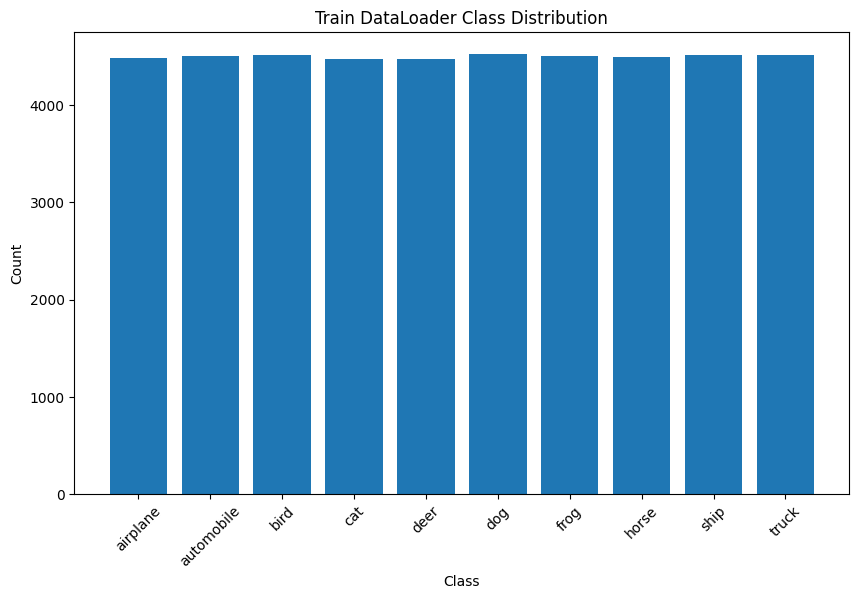

Validation DataLoader Distribution:
  airplane: 515
  automobile: 494
  bird: 486
  cat: 523
  deer: 529
  dog: 479
  frog: 495
  horse: 504
  ship: 489
  truck: 486


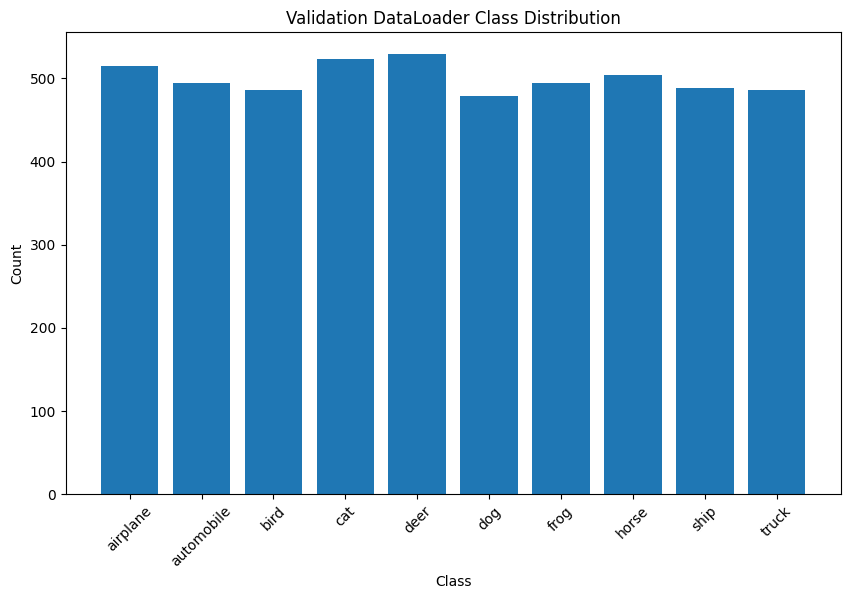

Test DataLoader Distribution:
  airplane: 1000
  automobile: 1000
  bird: 1000
  cat: 1000
  deer: 1000
  dog: 1000
  frog: 1000
  horse: 1000
  ship: 1000
  truck: 1000


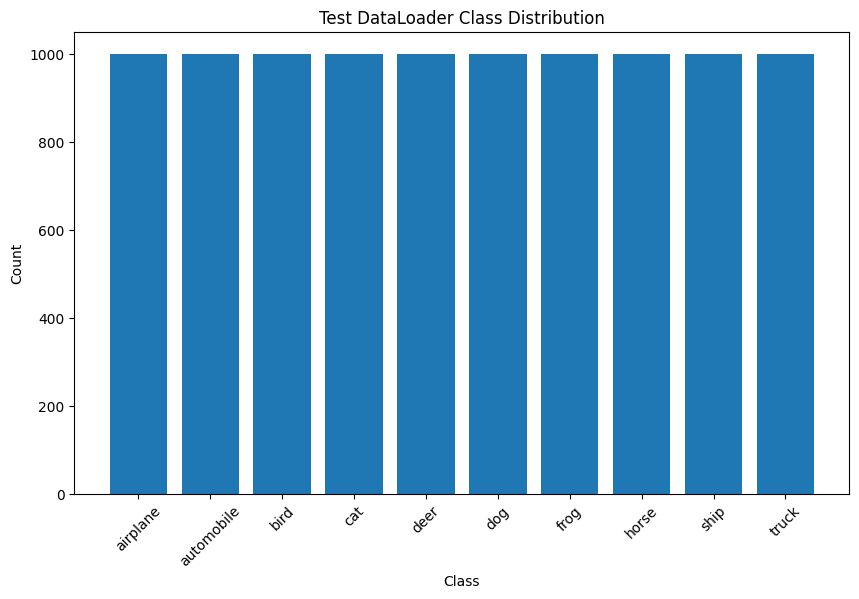

In [ ]:
# CIFAR-10 classes.
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Compute and display class distribution for each DataLoader.
for loader, name in [(train_loader, "Train"), (val_loader, "Validation"), (test_loader, "Test")]:
    distribution = get_class_distribution(loader, cifar10_classes)
    print(f"{name} DataLoader Distribution:")
    for cls, count in distribution.items():
        print(f"  {cls}: {count}")
    display_class_distribution(distribution, title=f"{name} DataLoader Class Distribution")

## Visualize CIFAR-10 images

Now let's visualize a few examples from each class in the CIFAR-10 dataset.

By displaying images alongside their corresponding class labels, we can verify the dataset’s contents and ensure the classes are represented correctly.

This visualization helps us understand the data distribution and provides insights into the dataset’s characteristics.

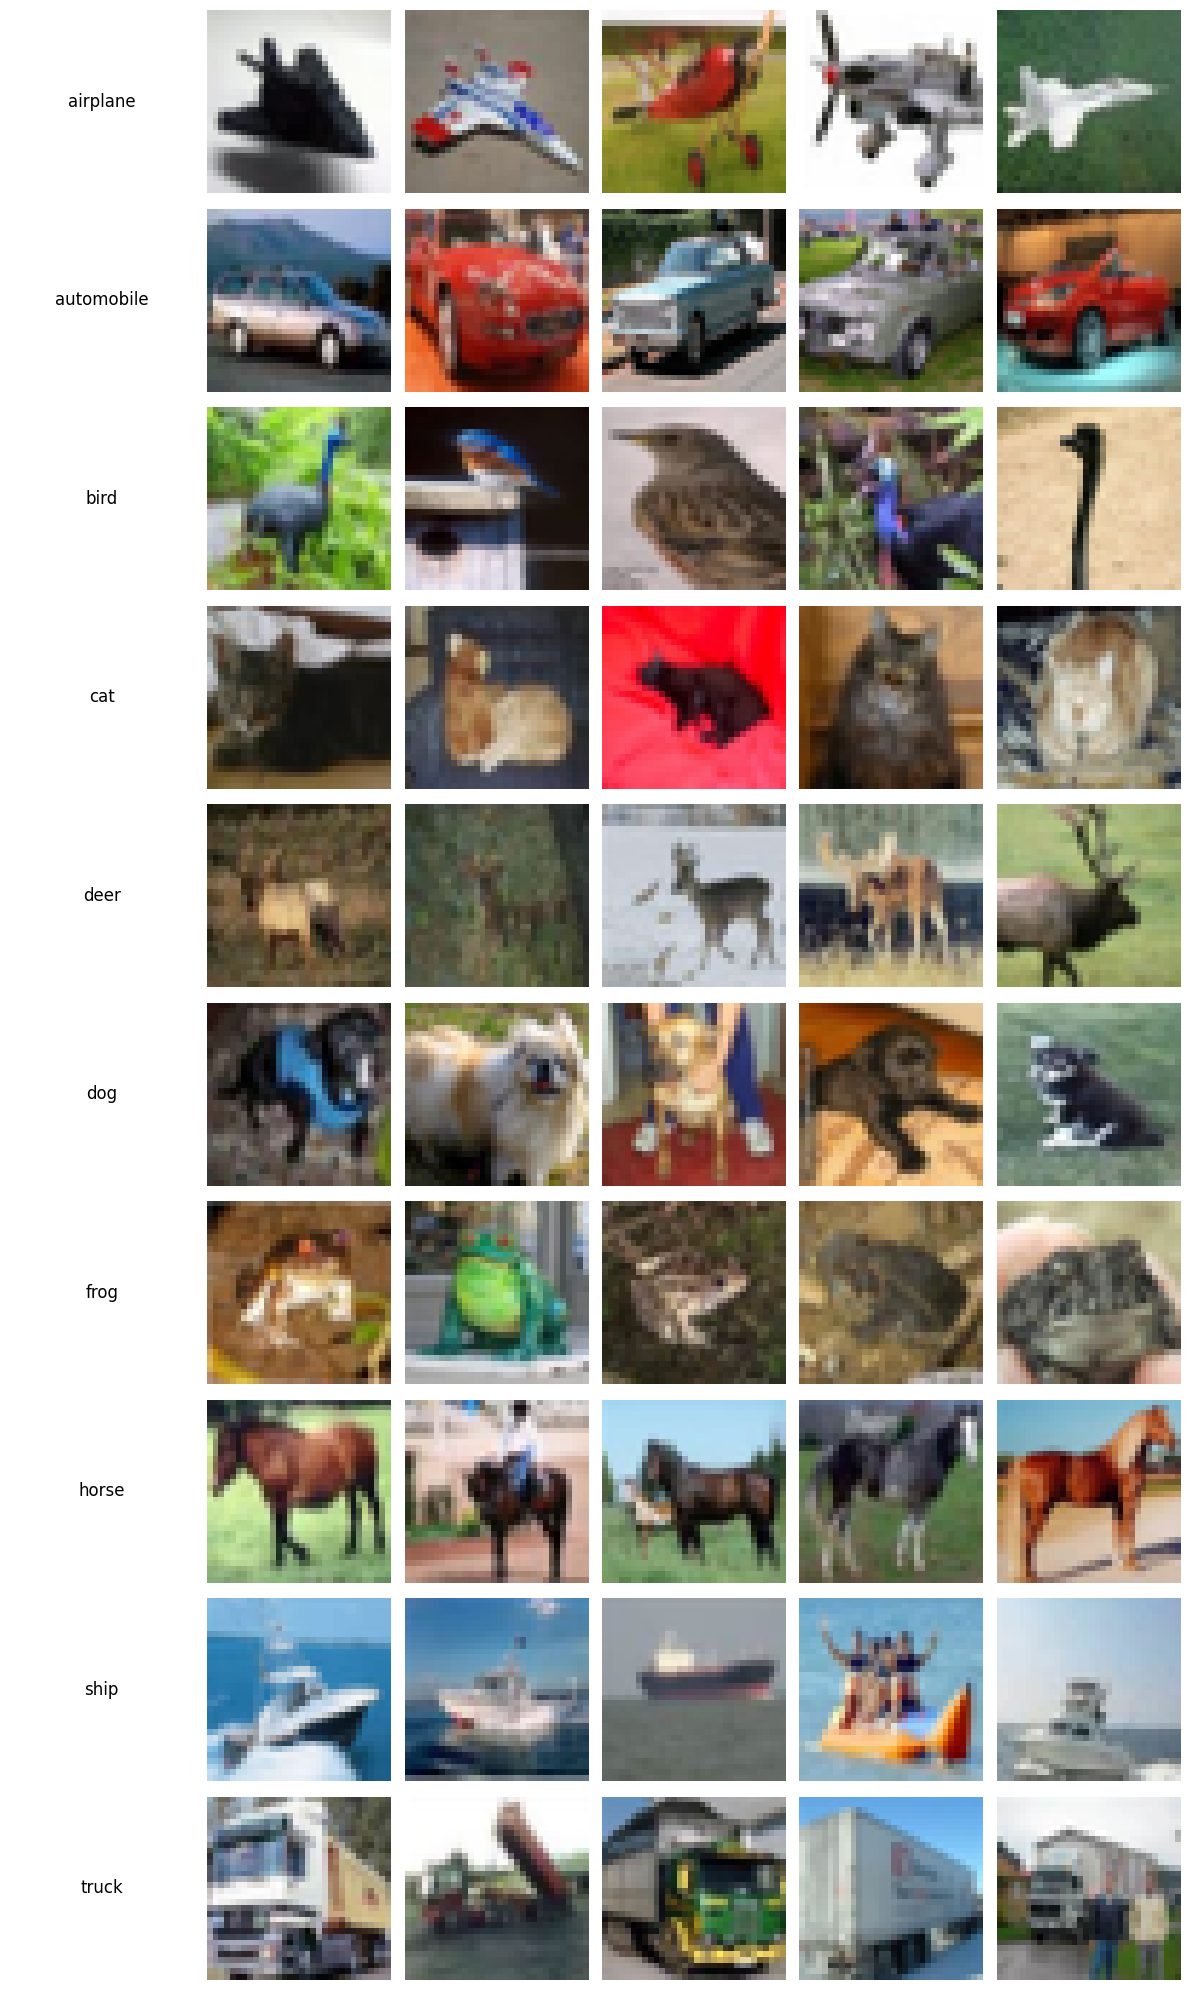

In [ ]:
import matplotlib.pyplot as plt

def visualize_images_per_class(dataset, dataset_classes, num_images=5):
    """
    Visualizes a few images from each class in the dataset.

    Args:
    - dataset: The dataset to sample from.
    - dataset_classes: List of class names for the dataset.
    - num_images: Number of images to display per class.
    """
    class_to_indices = {cls: [] for cls in range(len(dataset_classes))}

    # Group indices by class.
    for idx, (_, label) in enumerate(dataset):
        if len(class_to_indices[label]) < num_images:
            class_to_indices[label].append(idx)
        if all(len(indices) == num_images for indices in class_to_indices.values()):
            break

    # Plot the images.
    fig, axes = plt.subplots(len(dataset_classes), num_images + 1, figsize=((num_images + 1) * 2, len(dataset_classes) * 2))
    for cls_idx, cls_name in enumerate(dataset_classes):
        indices = class_to_indices[cls_idx]

        # Add class name to the first column of each row.
        axes[cls_idx, 0].text(0.5, 0.5, cls_name, fontsize=12, ha='center', va='center', transform=axes[cls_idx, 0].transAxes)
        axes[cls_idx, 0].axis("off")

        for img_idx, data_idx in enumerate(indices):
            img, label = dataset[data_idx]
            ax = axes[cls_idx, img_idx + 1]  # Shift by 1 for the class name column.
            img = img.permute(1, 2, 0)  # Convert CHW to HWC.
            img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize.
            img = torch.clamp(img, 0, 1)  # Clip values to valid range.
            ax.imshow(img)
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize 5 images per class for CIFAR-10 train set.
visualize_images_per_class(cifar10_dataset, cifar10_classes, num_images=5)

# Part II. Three-Layer ConvNet with Barebone PyTorch

## Barebone PyTorch: Three-Layer ConvNet

Here, we will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like previously, we can immediately test our implementation by passing zeros through the network. The network will have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two.
2. ReLU nonlinearity.
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one.
4. ReLU nonlinearity.
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for us, and by bundling that step in makes computation more efficient. For convolutions, see [Pytorch Documentation](http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d).

In [ ]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?

    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    # Implement the forward pass for the three-layer ConvNet.

    # 1st block.
    conv1 = F.conv2d(x, conv_w1, conv_b1, padding=2)
    relu1 = F.relu(conv1)

    # 2nd block.
    conv2 = F.conv2d(relu1, conv_w2, conv_b2, padding=1)
    relu2 = F.relu(conv2)

    # Flatten(3, H, W) and output.
    relu2_flattened = torch.flatten(relu2, start_dim=1)
    scores = relu2_flattened @ fc_w + fc_b

    return scores

After defining the forward pass of the ConvNet above, we run the following cell to test our implementation.

In [ ]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # Minibatch size 64, image size [3, 32, 32].

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W].
    conv_b1 = torch.zeros((6,))  # out_channel.
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W].
    conv_b2 = torch.zeros((9,))  # out_channel.

    # Calculate the shape of the tensor after two conv layers, before the fully-connected layer.
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # Expected [64, 10].
three_layer_convnet_test()

torch.Size([64, 10])


## Barebone PyTorch: Initialization

Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [ ]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight.
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW].
    # randn is standard normal distribution generator.
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# Create a weight of shape [3 x 5].
random_weight((3, 5))

tensor([[-0.0369, -0.0114,  0.4455, -0.1132, -0.2698],
        [ 1.2071, -1.3088, -1.2257, -0.2953,  1.3155],
        [ 0.5341,  0.3858, -0.0682,  0.4055,  0.6656]], device='cuda:0',
       requires_grad=True)

## Barebone PyTorch: Check Accuracy

When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [ ]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    # Split = 'val' if loader.dataset.train else 'test'.
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to GPU, if available..
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

## BareBone PyTorch: Training Loop

We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [ ]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.

    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD

    Returns: Nothing
    """
    for t, (x, y) in enumerate(train_loader):
        # Move the data to the proper device (GPU or CPU).
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss.
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational graph has requires_grad=True and uses backpropagation to compute the gradient of the loss with respect to these Tensors, and stores the gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the parameter updates, so we scope the updates under a torch.no_grad() context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass.
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(val_loader, model_fn, params)
            print()

## BareBone PyTorch: Training a ConvNet

We will use the functions defined above to train a three-layer convolutional network on CIFAR-10. The network will have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2.
2. ReLU.
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1.
4. ReLU.
5. Fully-connected layer (with bias) to compute scores for 10 classes.

We initialize our weight matrices using the `random_weight` function defined above, and we also initialize our bias vectors using the `zero_weight` function above to train just for one epoch.

In [ ]:
learning_rate = 3e-4

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

# Initialize the parameters of a three-layer ConvNet.
conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight((channel_1,))
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight((channel_2,))
fc_w = random_weight((channel_2 * 32 * 32, 10))
fc_b = zero_weight((10,))

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.2295
Checking accuracy on the val set
Got 539 / 5000 correct (10.78%)

Iteration 100, loss = 2.2949
Checking accuracy on the val set
Got 1042 / 5000 correct (20.84%)

Iteration 200, loss = 2.1615
Checking accuracy on the val set
Got 1179 / 5000 correct (23.58%)

Iteration 300, loss = 2.0361
Checking accuracy on the val set
Got 1361 / 5000 correct (27.22%)

Iteration 400, loss = 1.8545
Checking accuracy on the val set
Got 1483 / 5000 correct (29.66%)

Iteration 500, loss = 2.0336
Checking accuracy on the val set
Got 1541 / 5000 correct (30.82%)

Iteration 600, loss = 1.7289
Checking accuracy on the val set
Got 1563 / 5000 correct (31.26%)

Iteration 700, loss = 1.7821
Checking accuracy on the val set
Got 1623 / 5000 correct (32.46%)



# Part III. Three-Layer ConvNet with PyTorch Module API

## Module API: Three-Layer ConvNet

Next, let's implement a 3-layer ConvNet followed by a fully connected layer using the `Module API`. The network architecture will be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2.
2. ReLU.
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1.
4. ReLU.
5. Fully-connected layer to `num_classes` classes.

We initialize the weight matrices of the model using the Kaiming normal initialization method, having always in mind [Pytorch Documentation](http://pytorch.org/docs/stable/nn.html#conv2d).


After the implementation of the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run our implementation in order to test our output scores.

In [ ]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        # Set up the layers you need for a three-layer ConvNet with the architecture defined above.
        self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        self.fc = nn.Linear(channel_2 * 32 * 32, num_classes)

        # Weight matrices initialization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.constant_(self.conv2.bias, 0)
        nn.init.kaiming_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, x):
        scores = None

        # Implement the forward function for a 3-layer ConvNet.
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)
        scores = self.fc(x)

        return scores

def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # Minibatch size 64, image size [3, 32, 32].
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # Expected a shape of [64, 10].
test_ThreeLayerConvNet()

torch.Size([64, 10])


## Module API: Check Accuracy

Given the validation or test set, we can check the classification accuracy of a neural network.

This version is slightly different from the one in part II, as we don't manually pass in the parameters anymore.

In [ ]:
def check_accuracy_part3(loader, model):
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    model.eval()  # Set model to evaluation mode.
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to GPU, if available.
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

## Module API: Training Loop


We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [ ]:
def train_part3(model, optimizer, epochs=1):
    """
    Train a model on EuroSAT using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # Move the model parameters to CPU/GPU.
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # Put model to training mode.
            x = x.to(device=device, dtype=dtype)  # Move to GPU.
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss in respect to each parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part3(val_loader, model)
                print()

## Module API: Train a Three-Layer ConvNet

Now, we will use the Module API to train a three-layer ConvNet on CIFAR-10. This should look very similar to training the two-layer network (train for one epoch, using stochastic gradient descent without momentum).

In [ ]:
learning_rate = 3e-4
channel_1 = 32
channel_2 = 16

model = None
optimizer = None

# Instantiate your ThreeLayerConvNet model and a corresponding optimizer.
model = ThreeLayerConvNet(in_channel=3, channel_1=channel_1, channel_2=channel_2, num_classes=len(cifar10_classes))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model.
train_part3(model, optimizer)

Iteration 0, loss = 3.0654
Checking accuracy on the val set
Got 726 / 5000 correct (14.52)

Iteration 100, loss = 2.1346
Checking accuracy on the val set
Got 1137 / 5000 correct (22.74)

Iteration 200, loss = 1.9959
Checking accuracy on the val set
Got 1329 / 5000 correct (26.58)

Iteration 300, loss = 1.9925
Checking accuracy on the val set
Got 1407 / 5000 correct (28.14)

Iteration 400, loss = 1.8968
Checking accuracy on the val set
Got 1539 / 5000 correct (30.78)

Iteration 500, loss = 1.7769
Checking accuracy on the val set
Got 1614 / 5000 correct (32.28)

Iteration 600, loss = 1.8881
Checking accuracy on the val set
Got 1666 / 5000 correct (33.32)

Iteration 700, loss = 1.7793
Checking accuracy on the val set
Got 1700 / 5000 correct (34.00)



# Part IV. Three-Layer ConvNet with PyTorch Sequential API

## Sequential API: Three-Layer ConvNet

This time, we will use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2.
2. ReLU.
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1.
4. ReLU.
5. Fully-connected layer (with bias) to compute scores for 10 classes.

We use the default PyTorch weight initialization and we will, again, train for one epoch, using stochastic gradient descent with Nesterov momentum 0.9.

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 3e-4

model = None
optimizer = None

# Rewrite the 2-layer ConvNet with bias from Part III with the Sequential API.
model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10, bias=True)
) # Train function also ensures to put it to device(if available!).

# Set the optimizer.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

# Train the model.
train_part3(model, optimizer)

Iteration 0, loss = 2.2839
Checking accuracy on the val set
Got 450 / 5000 correct (9.00)

Iteration 100, loss = 2.0657
Checking accuracy on the val set
Got 1449 / 5000 correct (28.98)

Iteration 200, loss = 1.8302
Checking accuracy on the val set
Got 1723 / 5000 correct (34.46)

Iteration 300, loss = 1.8676
Checking accuracy on the val set
Got 1826 / 5000 correct (36.52)

Iteration 400, loss = 1.8112
Checking accuracy on the val set
Got 1922 / 5000 correct (38.44)

Iteration 500, loss = 2.0229
Checking accuracy on the val set
Got 2019 / 5000 correct (40.38)

Iteration 600, loss = 1.7344
Checking accuracy on the val set
Got 2101 / 5000 correct (42.02)

Iteration 700, loss = 1.6065
Checking accuracy on the val set
Got 2129 / 5000 correct (42.58)



## Sequential API: Experiment with Optimizers

Having implemented the baseline three-layer convolutional network model with PyTorch's Sequential API (as defined above), our task now is to perform a learning rate search for each optimizer to find the learning rate that yields the best accuracy on the validation set (train this model for 1 epoch using as **optimizers**: `SGD with momentum`, `Adagrad`, `RMSProp`, `Adam`, `AdamW` and `NAdam`, using the PyTorch documentation about [optimizers](https://pytorch.org/docs/stable/optim.html.) to implement these optimizers). We will use `channel_1 = 32`, `channel_2 = 16`.


In [ ]:
def check_accuracy_part3(loader, model):
    """
    Check the accuracy of a classification model using nn.Module API.

    Inputs:
    - loader: A DataLoader for the data split we want to check.
    - model: A PyTorch model instance (subclass of nn.Module).

    Returns:
    - acc: Accuracy of the model on the dataset (as a percentage).
    """
    split = 'val' if len(loader) == 79 else 'test'
    print('Checking accuracy on the %s set' % split)

    num_correct, num_samples = 0, 0
    model.eval()  # Set the model to evaluation mode.
    with torch.no_grad():  # Disable gradient computation.
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move input to device.
            y = y.to(device=device, dtype=torch.long)  # Move labels to device with correct dtype.

            # Forward pass using the model.
            scores = model(x)
            _, preds = scores.max(1)  # Get class predictions.

            num_correct += (preds == y).sum().item()  # Increment correct predictions.
            num_samples += preds.size(0)  # Increment total samples.

    acc = (float(num_correct) / num_samples) * 100
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, acc))
    return acc

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

# Define the optimizers to test.
optimizers_to_test = {
    "SGD with momentum": lambda model, lr: torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True),
    "Adagrad": lambda model, lr: torch.optim.Adagrad(model.parameters(), lr=lr),
    "RMSProp": lambda model, lr: torch.optim.RMSprop(model.parameters(), lr=lr),
    "Adam": lambda model, lr: torch.optim.Adam(model.parameters(), lr=lr),
    "AdamW": lambda model, lr: torch.optim.AdamW(model.parameters(), lr=lr),
    "NAdam": lambda model, lr: torch.optim.NAdam(model.parameters(), lr=lr),
}

results = []

# Test the three-layer ConvNet with different optimizers and learning rates.
import pandas as pd

# Updated function to return calculated accuracy as a percentage.
def check_accuracy_part3_updated(loader, model):
  split = 'val' if len(loader) == 79 else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  model.eval()  # Set model to evaluation mode.
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # Move to GPU.
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

  return acc * 100  # Return accuracy as a percentage.

# Loop over optimizers.
for optimizer_name, optimizer_fn in optimizers_to_test.items():
  best_val_accuracy = 0
  best_learning_rate = None
  for lr in learning_rates:
    print(f"\nTesting Optimizer: {optimizer_name} with learning rate: {lr}")

    # 1. Re-define the model(same as above) for the current combo.
    model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10, bias=True)
    ).to(device)  # Ensure model is moved to the device(despite it's already in train fn, I get error here!).

    # 2. Define the optimizer and lr.
    optimizer = optimizer_fn(model, lr)

    # 3. Train the model(only 1 epoch).
    train_part3(model, optimizer, epochs=1)

    # 4. Calculate the val accuracy and keep track of the best.
    val_accuracy = check_accuracy_part3_updated(val_loader, model)
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_learning_rate = lr

  # Print best results for the current optimizer.
  print(f"\nBest learning rate for {optimizer_name}: {best_learning_rate}")
  print(f"Best validation accuracy for {optimizer_name}: {best_val_accuracy}\n")

  # Save the results.
  results.append((optimizer_name, best_learning_rate, best_val_accuracy))

# Print the results in a table in desc order.
print("\nBest onfigurations:")
optimizers_df = pd.DataFrame(results, columns=['Optimizer', 'Best Learning Rate', 'Validation Accuracy (%)'])
optimizers_df = optimizers_df.sort_values(by='Validation Accuracy (%)', ascending=False)
print("\n", optimizers_df.to_string(index=False))


Testing Optimizer: SGD with momentum with learning rate: 0.1
Iteration 0, loss = 2.3039
Checking accuracy on the val set
Got 642 / 5000 correct (12.84%)

Iteration 100, loss = 2.3158
Checking accuracy on the val set
Got 489 / 5000 correct (9.78%)

Iteration 200, loss = 2.3203
Checking accuracy on the val set
Got 494 / 5000 correct (9.88%)

Iteration 300, loss = 2.3083
Checking accuracy on the val set
Got 515 / 5000 correct (10.30%)

Iteration 400, loss = 2.2887
Checking accuracy on the val set
Got 494 / 5000 correct (9.88%)

Iteration 500, loss = 2.3176
Checking accuracy on the val set
Got 494 / 5000 correct (9.88%)

Iteration 600, loss = 2.3109
Checking accuracy on the val set
Got 494 / 5000 correct (9.88%)

Iteration 700, loss = 2.2971
Checking accuracy on the val set
Got 504 / 5000 correct (10.08%)

Checking accuracy on the val set
Got 504 / 5000 correct (10.08)

Testing Optimizer: SGD with momentum with learning rate: 0.01
Iteration 0, loss = 2.3106
Checking accuracy on the val se

Keep the best classification results (based on validation accuracy) per optimizer in the following Table:

| Optimizer | best LR | Validation Accuracy (%) |
|----------|----------|----------|
| AdamW    | 1e-3   | 57.20   |
| Adam    | 1e-3   | 56.88   |
| SGD + momentum    | 1e-3   | 49.72   |
| RMSProp    | 1e-3   | 49.48   |
| NAdam    | 1e-3   | 48.86   |
| Adagrad    | 1e-3   | 48.50   |







## Sequential API: Experiment with Activation Functions

Using the optimizer and learning rate that performed the best in the previous question, we train the three-layer convolutional network for 1 epoch using different **activation functions**: `Leaky ReLU`, `ELU`, `GeLU`, `PReLU`, `SiLU` and `Mish`, using the PyTorch documentation about [non-linear activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). We track the validation accuracy for each activation function and select the one that performs best. We will also use `channel_1 = 32`, `channel_2 = 16`.

In [ ]:
channel_1 = 32
channel_2 = 16
best_learning_rate = 1e-3
best_optimizer_fn = lambda model: torch.optim.AdamW(model.parameters(), lr=best_learning_rate)

# Define activation functions to test.
activation_functions = {
    "ReLU": nn.ReLU(),
    "Leaky ReLU": nn.LeakyReLU(negative_slope=0.01),
    "ELU": nn.ELU(),
    "GeLU": nn.GELU(),
    "PReLU": nn.PReLU(),
    "SiLU": nn.SiLU(),
    "Mish": nn.Mish(),
}

results = []

# Test the three-layer ConvNet with different activation functions.
for activation_name, activation_fn in activation_functions.items():
  print(f"Testing Activation Function: {activation_name}")
  best_val_accuracy = 0

  # re-define the model for each activation function.
  model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=2),
    activation_fn,
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
    activation_fn,
    nn.Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10, bias=True)
    ).to(device)

  # Define optimizer.
  optimizer = best_optimizer_fn(model)

  # Train the model for 1 epoch, using the best optimizer and lr found above.
  train_part3(model, optimizer, epochs=1)

  # Calculate val_accuracy and track the best one.
  val_accuracy = check_accuracy_part3_updated(val_loader, model)
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy

  # Print best val_accuracy for the current activation function.
  print(f"\nBest validation accuracy for {activation_name}: {best_val_accuracy}\n")

  # Save the results.
  results.append((activation_name, best_val_accuracy))

# Put the results in pandas and print it.
activation_functions_df = pd.DataFrame(results, columns=['Activation Function', 'Validation Accuracy (%)'])
activation_functions_df = activation_functions_df.sort_values(by='Validation Accuracy (%)', ascending=False)
print("\n", activation_functions_df.to_string(index=False))

Testing Activation Function: ReLU
Iteration 0, loss = 2.3110
Checking accuracy on the val set
Got 495 / 5000 correct (9.90%)

Iteration 100, loss = 1.7294
Checking accuracy on the val set
Got 2088 / 5000 correct (41.76%)

Iteration 200, loss = 1.4730
Checking accuracy on the val set
Got 2303 / 5000 correct (46.06%)

Iteration 300, loss = 1.4894
Checking accuracy on the val set
Got 2549 / 5000 correct (50.98%)

Iteration 400, loss = 1.3852
Checking accuracy on the val set
Got 2604 / 5000 correct (52.08%)

Iteration 500, loss = 1.1848
Checking accuracy on the val set
Got 2723 / 5000 correct (54.46%)

Iteration 600, loss = 1.1782
Checking accuracy on the val set
Got 2682 / 5000 correct (53.64%)

Iteration 700, loss = 1.3181
Checking accuracy on the val set
Got 2864 / 5000 correct (57.28%)

Checking accuracy on the val set
Got 2804 / 5000 correct (56.08)

Best validation accuracy for ReLU: 56.08

Testing Activation Function: Leaky ReLU
Iteration 0, loss = 2.2779
Checking accuracy on the va

Keep the classification results in the following Table:

| Activation function | Validation Accuracy (%) |
|----------|----------|
| PReLU    | 58.96   |
| GeLU    | 58.46   |
| Leaky ReLU    | 57.62   |
| ReLU    | 56.08   |
| SiLU    | 52.94   |
| Mish    | 52.32   |
| ELU    | 49.36   |



## Sequential API: Experiment with Channels Sizes (number of filters)

$\color{pink}{\textit CodeQuestion:}$

Using the best optimizer, learning rate, and activation function from the previous experiments, we train the three-layer convolutional network for 1 epoch with different channel sizes. We experiment with the following channel sizes for the convolutional layers:

- `channel_1 = 16`, `channel_2 = 8`
- `channel_1 = 32`, `channel_2 = 16`
- `channel_1 = 64`, `channel_2 = 32`

Testing Channel Sizes: (channel_1, channel_2) = (16, 8)
Iteration 0, loss = 2.3035
Checking accuracy on the val set
Got 771 / 5000 correct (15.42%)

Iteration 100, loss = 1.5045
Checking accuracy on the val set
Got 2097 / 5000 correct (41.94%)

Iteration 200, loss = 1.5113
Checking accuracy on the val set
Got 2288 / 5000 correct (45.76%)

Iteration 300, loss = 1.3883
Checking accuracy on the val set
Got 2415 / 5000 correct (48.30%)

Iteration 400, loss = 1.4734
Checking accuracy on the val set
Got 2544 / 5000 correct (50.88%)

Iteration 500, loss = 1.2718
Checking accuracy on the val set
Got 2523 / 5000 correct (50.46%)

Iteration 600, loss = 1.1947
Checking accuracy on the val set
Got 2592 / 5000 correct (51.84%)

Iteration 700, loss = 1.3454
Checking accuracy on the val set
Got 2571 / 5000 correct (51.42%)

Checking accuracy on the val set
Got 2581 / 5000 correct (51.62)
Checking accuracy on the test set
Got 25386 / 45000 correct (56.41)
Best validation accuracy for (channel_1, chann

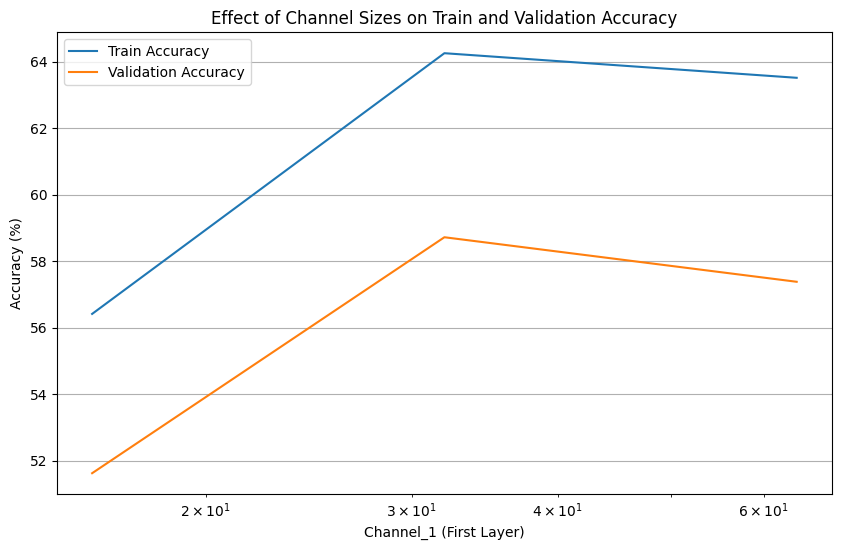

In [ ]:
# Define the channel size configurations to test.
channel_sizes = [
    (16, 8),
    (32, 16),
    (64, 32)
]

best_learning_rate = 1e-3
best_optimizer_fn = lambda model: torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
best_activation_fn = nn.PReLU()

results = {"Channel_1": [], "Train Accuracy": [], "Validation Accuracy": []}

# Test the three-layer ConvNet with different channel sizes. Train the model and record the train and validation accuracy for each configuration.
for channel_1, channel_2 in channel_sizes:
  print(f"Testing Channel Sizes: (channel_1, channel_2) = ({channel_1}, {channel_2})")
  best_val_accuracy = 0

  # Re-define the model for each channel size.
  model = nn.Sequential(
  nn.Conv2d(3, channel_1, kernel_size=5, padding=2),
  best_activation_fn,
  nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
  best_activation_fn,
  nn.Flatten(),
  nn.Linear(channel_2 * 32 * 32, 10, bias=True)
  ).to(device)

  # Define best optimizer.
  optimizer = best_optimizer_fn(model)

  # Train the model.
  train_part3(model, optimizer, epochs=1)

  # Calculate val_accuracy and track the best one.
  val_accuracy = check_accuracy_part3_updated(val_loader, model)
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy

  # Check the training accuracy here.
  train_accuracy = check_accuracy_part3_updated(train_loader, model)

  # Print the best val_acccuracy for the current combo of channels.
  print(f"Best validation accuracy for (channel_1, channel_2) = ({channel_1}, {channel_2}): {best_val_accuracy}\n")

  # Save the results.
  results["Channel_1"].append(channel_1)
  results["Train Accuracy"].append(train_accuracy)
  results["Validation Accuracy"].append(val_accuracy)

# Print of all the results in desc order.
results = pd.DataFrame(results)
print(results)

# Plot the results.
import matplotlib.pyplot as plt

def plot_channel_size_results(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results["Channel_1"], results["Train Accuracy"], label="Train Accuracy")
    plt.plot(results["Channel_1"], results["Validation Accuracy"], label="Validation Accuracy")
    plt.xscale("log")  # Log scale for better visibility of channel sizes.
    plt.xlabel("Channel_1 (First Layer)")
    plt.ylabel("Accuracy (%)")
    plt.title("Effect of Channel Sizes on Train and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_channel_size_results(results)

## Sequential API: Evaluate the final ConvNet model on the test set of CIFAR-10

Using the best configuration found during the previous experiments (optimizer, learning rate, activation function, and channel sizes), we train the model for 5 epoch and evaluate its performance on the test set.

In [ ]:
# Train the three-layer ConvNet with the best configuration found during the previous experiments and evaluate its performance on the test set.
import time

# Best configuration founded above.
best_learning_rate = 1e-3
best_optimizer_fn = lambda model: torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
best_activation_fn = nn.PReLU()
best_channel_1 = 32
best_channel_2 = 16

val_accuracies = []

# Define best model.
model = nn.Sequential(
  nn.Conv2d(3, channel_1, kernel_size=5, padding=2),
  best_activation_fn,
  nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
  best_activation_fn,
  nn.Flatten(),
  nn.Linear(channel_2 * 32 * 32, 10, bias=True)
  ).to(device)

# Define optimizer.
optimizer = best_optimizer_fn(model)

print("Training the model with the best configuration...")

# Measure training time.
tic = time.time()
for epoch in range(5):
  print(f"\nEpoch {epoch + 1}/{5}")

  # Train the model.
  train_part3(model, optimizer, epochs=1)

  # Calculate and store val_accuracies.
  val_accuracy = check_accuracy_part3_updated(val_loader, model)
  val_accuracies.append(val_accuracy)
toc = time.time()

# Calculate model's training time.
print(f"\nTraining time: {toc - tic:.2f} seconds")

# Calculate model's trainable params.
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# Evaluate on the test set.
print("\nEvaluating on the test set...")
test_acccuracy = check_accuracy_part3_updated(test_loader, model)

Training the model with the best configuration...

Epoch 1/5
Iteration 0, loss = 2.3111
Checking accuracy on the val set
Got 914 / 5000 correct (18.28%)

Iteration 100, loss = 1.4603
Checking accuracy on the val set
Got 2238 / 5000 correct (44.76%)

Iteration 200, loss = 1.4708
Checking accuracy on the val set
Got 2498 / 5000 correct (49.96%)

Iteration 300, loss = 1.3674
Checking accuracy on the val set
Got 2677 / 5000 correct (53.54%)

Iteration 400, loss = 1.1918
Checking accuracy on the val set
Got 2783 / 5000 correct (55.66%)

Iteration 500, loss = 1.2523
Checking accuracy on the val set
Got 2961 / 5000 correct (59.22%)

Iteration 600, loss = 1.1779
Checking accuracy on the val set
Got 2984 / 5000 correct (59.68%)

Iteration 700, loss = 1.0557
Checking accuracy on the val set
Got 3011 / 5000 correct (60.22%)

Checking accuracy on the val set
Got 3027 / 5000 correct (60.54)

Epoch 2/5
Iteration 0, loss = 1.2533
Checking accuracy on the val set
Got 3060 / 5000 correct (61.20%)

Iter

# Train ResNet-18 from scratch

So far, we've tried to design and train a **custom** three-layer convolutional network to the best of our ability.

However, in the literature, there are **well-known** convolutional architectures that are highly effective for image classification tasks.

We load a pre-defined [ResNet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model from the `torchvision.models` library, modify it for CIFAR-10 classification (10 output classes) and train it from scratch for 5 epochs using the train_part3 function. We report the validation accuracy after each epoch and evaluate the test accuracy at the end.

In [ ]:
import torchvision.models as models
# Load the ResNet-18 model from torchvision, modify it for CIFAR-10, train it from scratch for 5 epochs, and evaluate on the test set.
resnet_model = models.resnet18(weights=None)

# Modify model's classifier to meet our needs.
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(cifar10_classes))

# Ensure model is on device.
resnet_model = resnet_model.to(device)

# Define optimizer.
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=1e-3)

# Train the model.
print("Training ResNet-18 from scratch...\n")
tic = time.time()
train_part3(resnet_model, optimizer, epochs=5)
toc = time.time()

# Calculate model's training time.
print(f"\nTraining time: {toc - tic:.2f} seconds")

# Calculate total trainable parameters.
total_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# Calculate the validation accuracy.
val_accuracy = check_accuracy_part3_updated(val_loader, resnet_model)

# Evaluate the model on the test set.
print("\nEvaluating ResNet-18 on the test set...")
test_accuracy = check_accuracy_part3_updated(test_loader, resnet_model)

Training ResNet-18 from scratch...

Iteration 0, loss = 2.6519
Checking accuracy on the val set
Got 510 / 5000 correct (10.20%)

Iteration 100, loss = 1.6566
Checking accuracy on the val set
Got 2024 / 5000 correct (40.48%)

Iteration 200, loss = 1.5879
Checking accuracy on the val set
Got 2383 / 5000 correct (47.66%)

Iteration 300, loss = 1.6961
Checking accuracy on the val set
Got 2517 / 5000 correct (50.34%)

Iteration 400, loss = 1.3630
Checking accuracy on the val set
Got 2360 / 5000 correct (47.20%)

Iteration 500, loss = 1.3138
Checking accuracy on the val set
Got 2645 / 5000 correct (52.90%)

Iteration 600, loss = 1.2220
Checking accuracy on the val set
Got 2909 / 5000 correct (58.18%)

Iteration 700, loss = 1.2400
Checking accuracy on the val set
Got 2868 / 5000 correct (57.36%)

Iteration 0, loss = 0.9928
Checking accuracy on the val set
Got 2593 / 5000 correct (51.86%)

Iteration 100, loss = 0.9054
Checking accuracy on the val set
Got 2901 / 5000 correct (58.02%)

Iteration

# Fine-tune a pre-trained ResNet-18

### Fine-tune only the classifier

In this question, we will explore **transfer learning** by leveraging a pretrained ResNet-18 model. Instead of training the entire model from scratch, we will:

1.	Load a [ResNet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model pretrained on [ImageNet-1k](https://www.image-net.org/download.php) using `torchvision.models`.

2.	Replace the final fully connected layer to output 10 classes (for CIFAR-10).

3.	Freeze all layers except the classifier.

4.	Train the model for 5 epochs, fine-tuning only the classifier, and evaluate its performance on the test set (use of `AdamW` optimizer with a `learning rate` of `1e-2`).

In [ ]:
import torchvision.models as models
# Perform transfer learning with a pretrained ResNet-18 model. We replace the final layer for CIFAR-10 classification, freeze all other layers, and fine-tune the classifier for 5 epochs. Finally, we evaluate the model on the test set.

# Load pre-trained resnet with IMAGENET1K_V1 weights.
resnet_model_2 = models.resnet18(weights='IMAGENET1K_V1')

# Replace the head of classifier.
resnet_model_2.fc = nn.Linear(resnet_model_2.fc.in_features, len(cifar10_classes))

# Freeze all layers except the classifier.
for param in resnet_model_2.parameters():
    param.requires_grad = False
for param in resnet_model_2.fc.parameters():
    param.requires_grad = True

# Ensure model is on device.
resnet_model_2 = resnet_model_2.to(device)

# Define optimizer.
optimizer = torch.optim.AdamW(resnet_model_2.parameters(), lr=1e-2)

# Train the model.
print("Fine-tuning the classifier of pretrained ResNet-18...\n")
tic = time.time()
train_part3(resnet_model_2, optimizer, epochs=5)
toc = time.time()

# Calculate total training time.
print(f"\nTraining time: {toc - tic:.2f} seconds\n")

# Calculate model's trainable parameters.
total_params = sum(p.numel() for p in resnet_model_2.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# Calculate the validation accuracy.
val_accuracy = check_accuracy_part3_updated(val_loader, resnet_model_2)

# Evaluate the model on the test set.
print("Evaluating the fine-tuned ResNet-18 on the test set...")
test_accuracy = check_accuracy_part3_updated(test_loader, resnet_model_2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.0MB/s]


Fine-tuning the classifier of pretrained ResNet-18...

Iteration 0, loss = 2.7197
Checking accuracy on the val set
Got 619 / 5000 correct (12.38%)

Iteration 100, loss = 2.0781
Checking accuracy on the val set
Got 1698 / 5000 correct (33.96%)

Iteration 200, loss = 2.3536
Checking accuracy on the val set
Got 1888 / 5000 correct (37.76%)

Iteration 300, loss = 1.7571
Checking accuracy on the val set
Got 1917 / 5000 correct (38.34%)

Iteration 400, loss = 2.0981
Checking accuracy on the val set
Got 1722 / 5000 correct (34.44%)

Iteration 500, loss = 2.5493
Checking accuracy on the val set
Got 1735 / 5000 correct (34.70%)

Iteration 600, loss = 2.3856
Checking accuracy on the val set
Got 1968 / 5000 correct (39.36%)

Iteration 700, loss = 2.3862
Checking accuracy on the val set
Got 1896 / 5000 correct (37.92%)

Iteration 0, loss = 1.7830
Checking accuracy on the val set
Got 1737 / 5000 correct (34.74%)

Iteration 100, loss = 2.5568
Checking accuracy on the val set
Got 1723 / 5000 correct 

### Fine-tune the whole network

In this section, we will fine-tune the entire pretrained ResNet-18 model for CIFAR-10 classification. Instead of freezing the backbone, we will:

1.	Load a [ResNet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model pretrained on ImageNet using `torchvision.models`.

2.	Replace the final fully connected layer to output 10 classes (for CIFAR-10).

3.	Fine-tune all layers of the model (i.e., allow updates to the entire network).

4.	Train the model for 5 epochs and evaluate its performance on the test set (use of `AdamW` optimizer with a `learning rate` of `1e-3).

In [ ]:
import torchvision.models as models
# Fine-tune the entire pretrained ResNet-18 model for CIFAR-10 by replacing the final layer for CIFAR-10 classification and update all model layers.

# Load the model and modify its classifier.
resnet_model_3 = models.resnet18(weights='DEFAULT') # Default means IMAGENET1K_V1 weights according documentation.
resnet_model_3.fc = nn.Linear(resnet_model_3.fc.in_features, len(cifar10_classes))

# Define optimizer and train for 5 epochs.
optimizer = torch.optim.AdamW(resnet_model_3.parameters(), lr=1e-3)
resnet_model_3 = resnet_model_3.to(device)
print("Fine-tuning the entire pretrained ResNet-18...\n")
tic = time.time()
train_part3(resnet_model_3, optimizer, epochs=5)
toc = time.time()

# Calculate total training time.
print(f"\nTraining time: {toc - tic:.2f} seconds\n")

# Calculate model's trainable params.
total_params = sum(p.numel() for p in resnet_model_3.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# Calculate the validation accuracy.
val_accuracy = check_accuracy_part3_updated(val_loader, resnet_model_3)

# Evaluate the model on the test set.
print("\nEvaluating the fine-tuned ResNet-18 on the test set...")
test_accuracy = check_accuracy_part3_updated(test_loader, resnet_model_3)

Fine-tuning the entire pretrained ResNet-18...

Iteration 0, loss = 2.4247
Checking accuracy on the val set
Got 687 / 5000 correct (13.74%)

Iteration 100, loss = 1.0673
Checking accuracy on the val set
Got 2994 / 5000 correct (59.88%)

Iteration 200, loss = 0.9215
Checking accuracy on the val set
Got 3047 / 5000 correct (60.94%)

Iteration 300, loss = 1.1492
Checking accuracy on the val set
Got 3419 / 5000 correct (68.38%)

Iteration 400, loss = 0.8188
Checking accuracy on the val set
Got 3427 / 5000 correct (68.54%)

Iteration 500, loss = 0.9535
Checking accuracy on the val set
Got 3647 / 5000 correct (72.94%)

Iteration 600, loss = 0.8493
Checking accuracy on the val set
Got 3576 / 5000 correct (71.52%)

Iteration 700, loss = 0.9224
Checking accuracy on the val set
Got 3485 / 5000 correct (69.70%)

Iteration 0, loss = 0.7462
Checking accuracy on the val set
Got 3123 / 5000 correct (62.46%)

Iteration 100, loss = 0.6896
Checking accuracy on the val set
Got 3735 / 5000 correct (74.70%

# Technical Report

$\color{lightblue}{\textit YourAnswer:}$

The table below shows the results from experiments of final custom ConvNet and all versions of ResNet-18.

1. Performance Comparison: as we see, we get a descent performance from our final custom ConvNet, but lower from the best one, due to its simpler architecture and lack of pretraining. Better performance from ResNet-18(trained from scratch), because is deeper and can capture more complex patterns. Freezing most of pre-trained layers, restricts adaption on our CIFAR-10 dataset, as ResNet-18 is pre-trained on ImageNet, and that is why we get a lower performance. Finally, the best performance is achieved by adapting the whole pre-trained ResNet-18 to our task. It effectively learned both high and low level features, therefore, by combining transfer learning and a thorough fine-tuning, we can get great performance results.

2. Efficiency: our final custom ConvNet is the most efficient, regarding training time, while training only the classifier of ResNet-18 takes a little more. In both these two cases, we have also few trainable parameters, in comparison with the other two models(especially when we train only the classifier of the ResNet-18), although, this comes with low performances. Training ResNet-18 from scratch and with entire fine-tuning, we take similar times and, of course, same amount of trainable parameters, along with higher accuracies. Best choice is the one that gives the highest accuracy, despite its big number of trainable parameters and the second higher training time achieved.

3. Recommendations: based on the results, the best approach for CIFAR-10 is to fine-tune the entire pre-trained ResNet-18. It achieves the highest test accuracy, with significant difference from others, despite it has large amount of trainable parameters and demands higher training time. And, obviously, this choice comes with the ease of implementation. According to the PyTorch documentation, pretrained models like ResNet-18 significantly simplify the process of model development. They reduce the effort and time needed to design and train a custom architecture from scratch, making them an efficient and practical choice for any application.

| Model                             | Training Time (s) | Total Prameters | Test Accuracy (%) |
|-----------------------------------|-------------------|-------------------|------------------|
| Custom ConvNet                    | 146.35            | 351019             | 62.97        |
| ResNet-18 (trained from scratch)  | 180.07            | 11181642             | 72.91       |
| ResNet-18 (classifier fine-tuned) | 165.84            | 5130             | 36.95         |
| ResNet-18 (entirely fine-tuned)   | 177.68            | 11181642             | 79.47       |